In [1]:
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [3]:
model_path = '/notebooks/caffe/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

In [4]:
def make_step(net, step_size=1.5, end='inception_4c/output', jitter=32, clip=True):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    dst.diff[:] = dst.data  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)

In [5]:
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

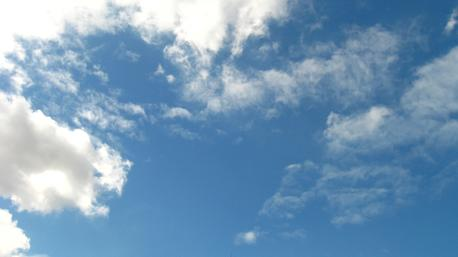

In [16]:
img = PIL.Image.open('/notebooks/caffe/Appearance_of_sky_for_weather_forecast,_Dhaka,_Bangladesh.JPG')
img.thumbnail((458, 816), PIL.Image.ANTIALIAS)
img = np.float32(img)
showarray(img)

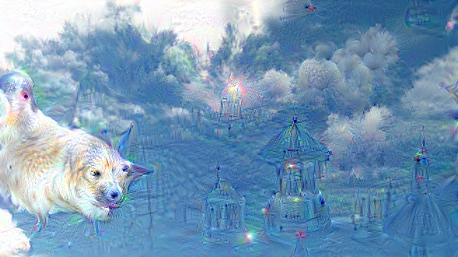

3 9 inception_4c/output (257, 458, 3)


In [17]:
_=deepdream(net, img)

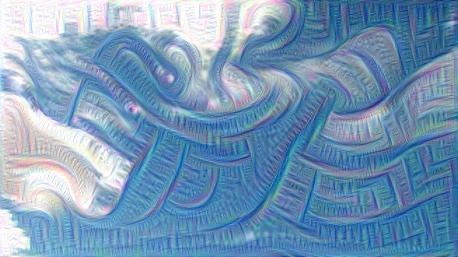

3 9 inception_3b/5x5_reduce (257, 458, 3)


In [18]:
_=deepdream(net, img, end='inception_3b/5x5_reduce')

In [20]:
net.blobs.keys()

['data',
 'conv1/7x7_s2',
 'pool1/3x3_s2',
 'pool1/norm1',
 'conv2/3x3_reduce',
 'conv2/3x3',
 'conv2/norm2',
 'pool2/3x3_s2',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_0',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_1',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_2',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_3',
 'inception_3a/1x1',
 'inception_3a/3x3_reduce',
 'inception_3a/3x3',
 'inception_3a/5x5_reduce',
 'inception_3a/5x5',
 'inception_3a/pool',
 'inception_3a/pool_proj',
 'inception_3a/output',
 'inception_3a/output_inception_3a/output_0_split_0',
 'inception_3a/output_inception_3a/output_0_split_1',
 'inception_3a/output_inception_3a/output_0_split_2',
 'inception_3a/output_inception_3a/output_0_split_3',
 'inception_3b/1x1',
 'inception_3b/3x3_reduce',
 'inception_3b/3x3',
 'inception_3b/5x5_reduce',
 'inception_3b/5x5',
 'inception_3b/pool',
 'inception_3b/pool_proj',
 'inception_3b/output',
 'pool3/3x3_s2',
 'pool3/3x3_s2_pool3/3x3_s2_0_split_0',
 'pool3/3x3_s2_pool3/3x3_s2_0_split_1',
 'pool3/3x3_s2_p

In [21]:
!mkdir frames
frame = img
frame_i = 0

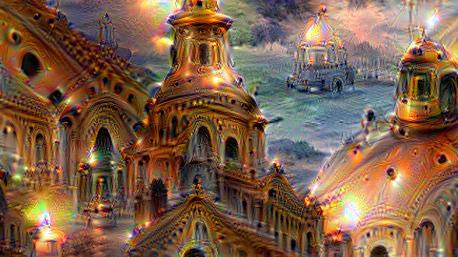

3 9 inception_4c/output (257, 458, 3)


In [22]:
h, w = frame.shape[:2]
s = 0.05 # scale coefficient
for i in xrange(100):
    frame = deepdream(net, frame)
    PIL.Image.fromarray(np.uint8(frame)).save("frames/%04d.jpg"%frame_i)
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    frame_i += 1

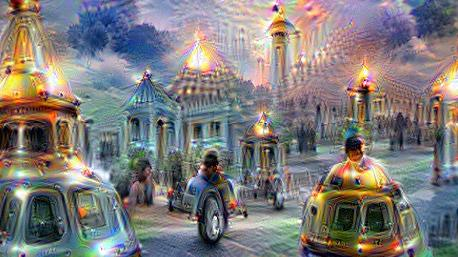

In [23]:
Image(filename='frames/0029.jpg')

In [34]:
from subprocess import check_output
# check_output(["chmod", "777", "frames"])
check_output(["tar", "-zcvf", "frames.tar.gz", "frames"])

'frames/\nframes/0028.jpg\nframes/0092.jpg\nframes/0021.jpg\nframes/0059.jpg\nframes/0057.jpg\nframes/0029.jpg\nframes/0039.jpg\nframes/0018.jpg\nframes/0048.jpg\nframes/0098.jpg\nframes/0019.jpg\nframes/0087.jpg\nframes/0010.jpg\nframes/0007.jpg\nframes/0052.jpg\nframes/0014.jpg\nframes/0040.jpg\nframes/0009.jpg\nframes/0023.jpg\nframes/0084.jpg\nframes/0022.jpg\nframes/0037.jpg\nframes/0016.jpg\nframes/0074.jpg\nframes/0085.jpg\nframes/0076.jpg\nframes/0080.jpg\nframes/0078.jpg\nframes/0072.jpg\nframes/0025.jpg\nframes/0003.jpg\nframes/0065.jpg\nframes/0043.jpg\nframes/0002.jpg\nframes/0042.jpg\nframes/0054.jpg\nframes/0064.jpg\nframes/0079.jpg\nframes/0095.jpg\nframes/0093.jpg\nframes/0031.jpg\nframes/0036.jpg\nframes/0071.jpg\nframes/0047.jpg\nframes/0050.jpg\nframes/0062.jpg\nframes/0090.jpg\nframes/0049.jpg\nframes/0081.jpg\nframes/0046.jpg\nframes/0061.jpg\nframes/0027.jpg\nframes/0056.jpg\nframes/0067.jpg\nframes/0041.jpg\nframes/0033.jpg\nframes/0020.jpg\nframes/0015.jpg\nfram